In [1]:
# 01_catalog_and_peek.ipynb — Cell 1
# Environment check: imports, versions, and data path verification.
# No data loading happens here.

from pathlib import Path
import sys, platform

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as mpl

import sklearn
import xgboost as xgb

# Repro-friendly display settings (safe, not heavy)
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Resolve data root (expected location for SAGraph files)
DATA_ROOT = Path("data/raw/SAGraph")

# Print environment summary
print("Environment")
print("-----------")
print(f"Python        : {sys.version.split()[0]}  ({platform.system()} {platform.release()})")
print(f"pandas        : {pd.__version__}")
print(f"numpy         : {np.__version__}")
print(f"networkx      : {nx.__version__}")
print(f"matplotlib    : {mpl.__version__}")
print(f"scikit-learn  : {sklearn.__version__}")
print(f"xgboost       : {xgb.__version__}")

# Verify data folder exists (fail early if not)
print("\nPaths")
print("-----")
print(f"DATA_ROOT     : {DATA_ROOT.resolve()}")
if not DATA_ROOT.exists():
    raise FileNotFoundError(
        "Expected SAGraph files under data/raw/SAGraph. "
        "Create this folder and place product_info.jsonl and the *.graph.anon files there."
    )
else:
    print("OK: DATA_ROOT exists.")

Environment
-----------
Python        : 3.11.14  (Darwin 24.6.0)
pandas        : 2.2.2
numpy         : 1.26.4
networkx      : 3.3
matplotlib    : 3.8.4
scikit-learn  : 1.4.2
xgboost       : 2.0.3

Paths
-----
DATA_ROOT     : /Users/ramana/Documents/Homework/2nd class Network Analytics/Project 2/Influence-Analysis/data/raw/SAGraph
OK: DATA_ROOT exists.


In [ ]:

import json
from pathlib import Path
import pandas as pd

info_file = DATA_ROOT / "product_info.jsonl"  # this is actually a JSON array

# 1) Load entire file as a JSON array
with info_file.open("r", encoding="utf-8") as f:
    info_list = json.load(f)   # list[dict] if file is a JSON array

if not isinstance(info_list, list):
    raise ValueError("Expected a JSON array in product_info.jsonl (found something else).")

info_df = pd.DataFrame(info_list)

# 2) Normalize influencer_ids to a clean list[int]
def to_int_list(x):
    if isinstance(x, list):
        vals = []
        for v in x:
            try:
                vals.append(int(v))
            except Exception:
                continue
        return vals
    return []

if "influencer_ids" in info_df.columns:
    info_df["influencer_ids"] = info_df["influencer_ids"].apply(to_int_list)
    info_df["influencer_ids_count"] = info_df["influencer_ids"].apply(len)
else:
    info_df["influencer_ids"] = [[] for _ in range(len(info_df))]
    info_df["influencer_ids_count"] = 0

# 3) Display basic structure
print("product_info overview")
print("---------------------")
print(f"rows: {len(info_df)}, columns: {list(info_df.columns)}")
display(info_df.head(3))
print("\ndtypes:")
print(info_df.dtypes)

# 4) Cross-check product names vs files we discovered
prof_names = {p.name.replace("_profile.graph.anon", "") for p in DATA_ROOT.glob("*_profile.graph.anon")}
inter_names = {p.name.replace("_interaction.graph.anon", "") for p in DATA_ROOT.glob("*_interaction.graph.anon")}
both_files = sorted(prof_names & inter_names)

names_from_info = sorted(info_df["product_name"].dropna().unique().tolist())

print("\nCross-check")
print("-----------")
print(f"Products in files : {len(both_files)} -> {both_files}")
print(f"Products in info  : {len(names_from_info)} -> {names_from_info}")

missing_in_info = sorted(set(both_files) - set(names_from_info))
missing_in_files = sorted(set(names_from_info) - set(both_files))
print(f"Missing in info   : {missing_in_info}")
print(f"Missing in files  : {missing_in_files}")

product_info overview
---------------------
rows: 6, columns: ['product_name', 'domain', 'ads', 'influencer_ids', 'influencer_ids_count']


,product_name,domain,ads,influencer_ids,influencer_ids_count
0,spark_thinking,education,火花思维11月活动海报见图！4880元到手48节课，赠送1W5火花币，听力熊听力机，科普书《...,"[162395, 172251, 177999, 171351, 163119]",5
1,electric_toothbrush,hygiene,之前让高速吹风机更加普及的#徕芬#，这次又来普及电动牙刷了，“果味”实足的外观，扫振一体的设...,"[146880, 136519, 67092, 132945, 70148, 139659,...",8
2,ruby_face_cream,skincare,红宝石面霜是我近几年用最多的面霜，超级爱用。升级后使用感更好了，用了之后感觉皮肤状态也很好。...,"[31027, 39487, 1, 30328, 8724, 16798, 20277, 3...",14



dtypes:
product_name            object
domain                  object
ads                     object
influencer_ids          object
influencer_ids_count     int64
dtype: object

Cross-check
-----------
Products in files : 6 -> ['abc_reading', 'electric_toothbrush', 'intelligent_floor_scrubber', 'ruby_face_cream', 'spark_thinking', 'supor_boosted_showerhead']
Products in info  : 6 -> ['abc_reading', 'electric_toothbrush', 'intelligent_floor_scrubber', 'ruby_face_cream', 'spark_thinking', 'supor_boosted_showerhead']
Missing in info   : []
Missing in files  : []


In [10]:
# Load interactions for TARGET_PRODUCT and compute summaries using dataset names

import json
from collections import Counter
import pandas as pd
from pathlib import Path

interactions_path = DATA_ROOT / f"{TARGET_PRODUCT}_interaction.graph.anon"
with interactions_path.open("r", encoding="utf-8") as f:
    inter_obj = json.load(f)  # {<key_user_id str>: [ {interact_id, interact_type, ...}, ... ]}

# counts per key_user_id (how many interaction records are attached to each dict key)
per_key_counts = pd.Series([len(v or []) for v in inter_obj.values()], name="interactions_per_key_user_id")
total_interactions = int(per_key_counts.sum())
key_user_count = int(per_key_counts.shape[0])

# interaction type mix (from the record field interact_type)
itype_counter = Counter()
for lst in inter_obj.values():
    for rec in lst or []:
        itype_counter[str(rec.get("interact_type", ""))] += 1
itype_df = pd.Series(itype_counter, name="n").sort_values(ascending=False).to_frame()

print("Interactions overview")
print("---------------------")
print(f"key_user_id count (dict keys): {key_user_count}")
print(f"total interactions            : {total_interactions}")
display(per_key_counts.describe(percentiles=[0.5, 0.9, 0.99]).to_frame())

print("interaction type counts (from interact_type):")
display(itype_df)

Interactions overview
---------------------
key_user_id count (dict keys): 9271
total interactions            : 458513


,interactions_per_key_user_id
count,9271.000000
mean,49.456693
std,470.109745
min,1.000000
50%,2.000000
90%,17.000000
99%,1246.300000
max,19535.000000


interaction type counts (from interact_type):


,n
comment,343882
reposts,114631


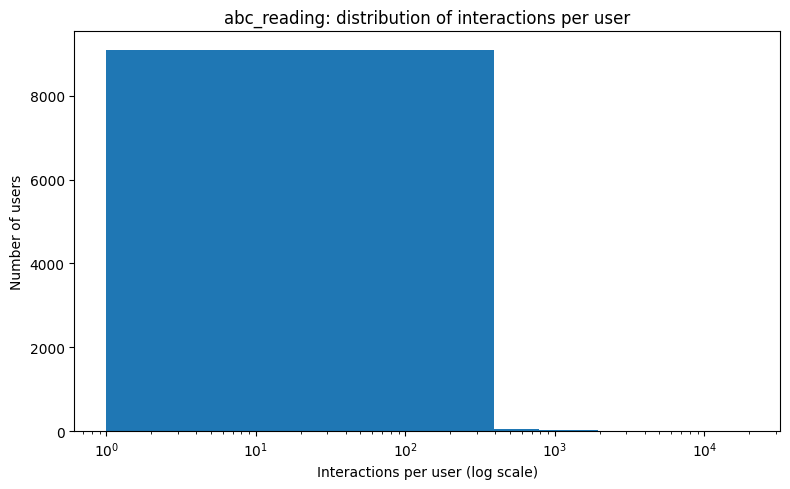

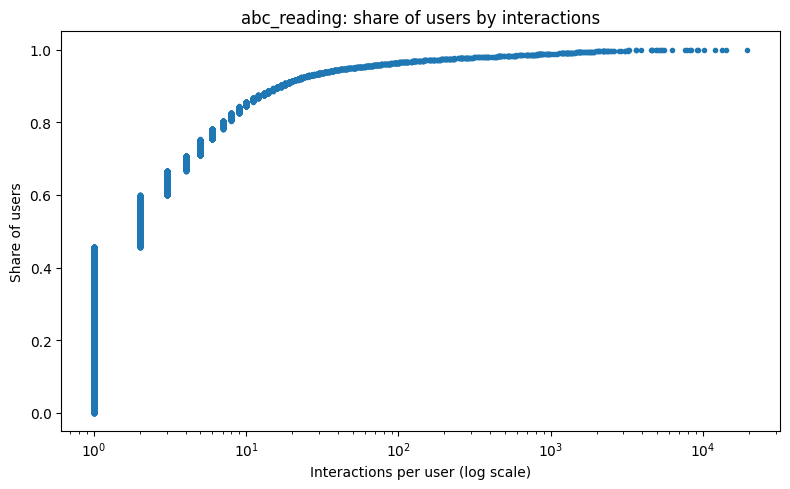

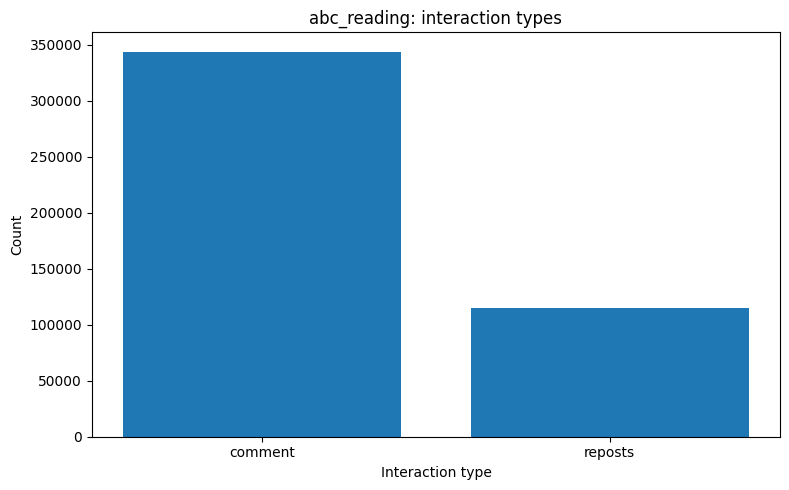

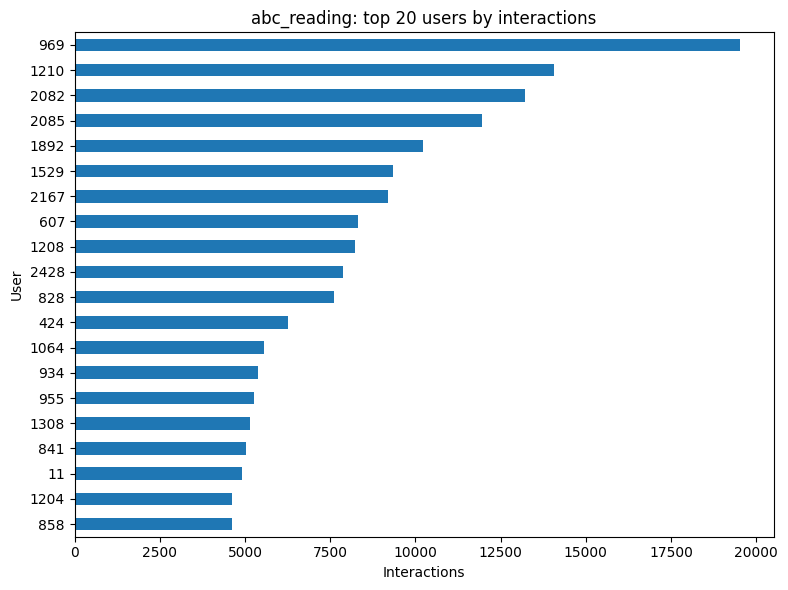

In [12]:
# Simple charts with plain labels

import numpy as np
import matplotlib.pyplot as plt

# 1) Histogram of interactions per user (log x)
plt.figure(figsize=(8, 5))
plt.hist(per_key_counts, bins=50)
plt.xscale("log")
plt.xlabel("Interactions per user (log scale)")
plt.ylabel("Number of users")
plt.title(f"{TARGET_PRODUCT}: distribution of interactions per user")
plt.tight_layout()
plt.show()

# 2) ECDF of interactions per user (log x)
x = np.sort(per_key_counts.values)
y = np.arange(1, len(x) + 1) / len(x)
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker=".", linestyle="none")
plt.xscale("log")
plt.xlabel("Interactions per user (log scale)")
plt.ylabel("Share of users")
plt.title(f"{TARGET_PRODUCT}: share of users by interactions")
plt.tight_layout()
plt.show()

# 3) Interaction type counts
labels = itype_df.index.tolist()
counts = itype_df["n"].to_numpy()
plt.figure(figsize=(8, 5))
plt.bar(range(len(labels)), counts)
plt.xticks(range(len(labels)), labels, rotation=0)
plt.xlabel("Interaction type")
plt.ylabel("Count")
plt.title(f"{TARGET_PRODUCT}: interaction types")
plt.tight_layout()
plt.show()

# 4) Top 20 users by interactions
top20 = per_key_counts.sort_values(ascending=False).head(20)
plt.figure(figsize=(8, 6))
top20.sort_values().plot(kind="barh")
plt.xlabel("Interactions")
plt.ylabel("User")
plt.title(f"{TARGET_PRODUCT}: top 20 users by interactions")
plt.tight_layout()
plt.show()

In [13]:
# Build an edge list from interactions and compute per-user engagement for this product

import json
import pandas as pd

# Load interactions as we did earlier
interactions_path = DATA_ROOT / f"{TARGET_PRODUCT}_interaction.graph.anon"
with interactions_path.open("r", encoding="utf-8") as f:
    inter_obj = json.load(f)  # {<user id as str>: [ {interact_id, interact_type, ...}, ... ]}

# Edge list: for each record, add a directed edge: interact_id -> key user (the dict key)
edges_rows = []
for key_user_str, lst in inter_obj.items():
    try:
        key_user = int(key_user_str)
    except Exception:
        continue
    for rec in lst or []:
        try:
            src = int(rec.get("interact_id"))
        except Exception:
            continue
        itype = str(rec.get("interact_type", ""))
        edges_rows.append((src, key_user, itype))

edges = pd.DataFrame(edges_rows, columns=["src_user_id", "dst_user_id", "interact_type"])
edges = edges.astype({"src_user_id": "int64", "dst_user_id": "int64"})

print("Edge list summary")
print("-----------------")
print(f"edges: {len(edges):,}")
print(f"unique users (any role): {len(pd.unique(pd.concat([edges['src_user_id'], edges['dst_user_id']]))) :,}")
print("interact_type counts:")
display(edges["interact_type"].value_counts().to_frame("n"))

# Aggregate engagement received by each destination user (the user referenced by the dict key)
eng = (
    edges
    .groupby(["dst_user_id", "interact_type"])
    .size()
    .unstack(fill_value=0)
    .rename_axis(None, axis=1)
)

# Ensure expected columns exist
for col in ["comment", "reposts"]:
    if col not in eng.columns:
        eng[col] = 0

eng["total_engagement"] = eng["comment"] + eng["reposts"]
eng = eng.reset_index().rename(columns={"dst_user_id": "user_id"})

# Join with the profiles we already loaded for this product (prof_df from earlier step)
# If prof_df is not in memory, we can reload it; assuming it's available here as per previous cell.
feat = (
    eng.merge(
        prof_df[["user_id", "user_followers", "user_friends"]],
        on="user_id",
        how="left",
    )
    .fillna({"user_followers": 0, "user_friends": 0})
)

# Simple rates for later modeling
feat["engagement_per_follower"] = feat["total_engagement"] / (feat["user_followers"].clip(lower=1))
feat["engagement_per_1000_followers"] = 1000.0 * feat["engagement_per_follower"]

print("\nPer-user engagement feature sample")
print("----------------------------------")
display(feat.head(10))

# Quick quality checks
print("\nQuality checks")
print("--------------")
missing_profiles = (feat["user_followers"].isna().sum())
print(f"rows missing profile fields after merge: {missing_profiles}")
print("basic stats:")
display(feat[["comment", "reposts", "total_engagement", "user_followers", "engagement_per_1000_followers"]]
        .describe(percentiles=[0.5, 0.9, 0.99]))

Edge list summary
-----------------
edges: 458,513
unique users (any role): 70,257
interact_type counts:


,n
interact_type,
comment,343882
reposts,114631



Per-user engagement feature sample
----------------------------------


,user_id,comment,reposts,total_engagement,user_followers,user_friends,engagement_per_follower,engagement_per_1000_followers
0,54,1,0,1,614,1550,1.628664e-03,1.628664
1,145,1,0,1,589,4295,1.697793e-03,1.697793
2,185,2500,5825,8325,16153761,1324,5.153599e-04,0.515360
3,189,1,0,1,3159,5099,3.165559e-04,0.316556
4,513,1,0,1,240068995,1104,4.165469e-09,0.000004
5,1224,1,0,1,5100,4945,1.960784e-04,0.196078
6,6848,1,0,1,808,312,1.237624e-03,1.237624
7,7704,1,0,1,7101,810,1.408252e-04,0.140825
8,9066,1,0,1,0,0,1.000000e+00,1000.000000
9,9069,1,0,1,0,0,1.000000e+00,1000.000000



Quality checks
--------------
rows missing profile fields after merge: 0
basic stats:


,comment,reposts,total_engagement,user_followers,engagement_per_1000_followers
count,9271.000000,9271.000000,9271.000000,9.271000e+03,9271.000000
mean,37.092223,12.364470,49.456693,1.425399e+05,421.632875
std,333.417527,222.692997,470.109745,2.564683e+06,4966.944586
min,1.000000,0.000000,1.000000,0.000000e+00,0.000004
50%,2.000000,0.000000,2.000000,8.660000e+02,2.849003
90%,17.000000,0.000000,17.000000,1.854530e+05,357.142857
99%,889.200000,119.500000,1246.300000,2.274796e+06,7150.000000
max,19279.000000,11758.000000,19535.000000,2.400690e+08,340000.000000


Self-loop cleanup
-----------------
edges before : 458,513
self-loops   : 18,893 (4.12%)
edges after  : 439,620

Graph overview (clean)
----------------------
nodes: 70,257
edges: 115,951

Top users by in-degree (distinct people who interacted)


,user_id,in_degree
84769,84769,5676
104785,104785,5077
185,185,4700
42692,42692,3928
71739,71739,3747
96967,96967,2901
84700,84700,2712
156296,156296,1703
84952,84952,1629
85447,85447,1625



Top users by PageRank (graph influence)


,user_id,pagerank
104785,104785,0.023752
156296,156296,0.014725
96967,96967,0.013268
84769,84769,0.012914
81584,81584,0.012461
42692,42692,0.011569
71739,71739,0.010970
185,185,0.009840
84700,84700,0.008042
85447,85447,0.007983


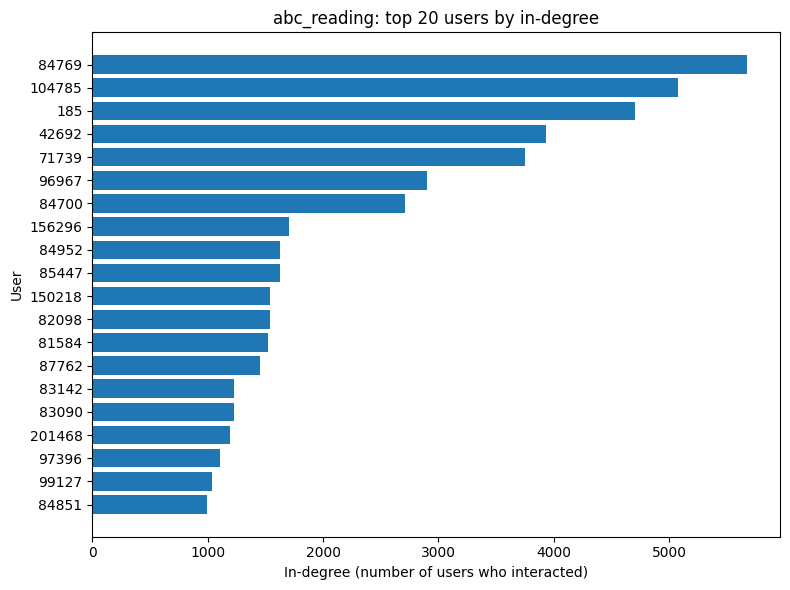

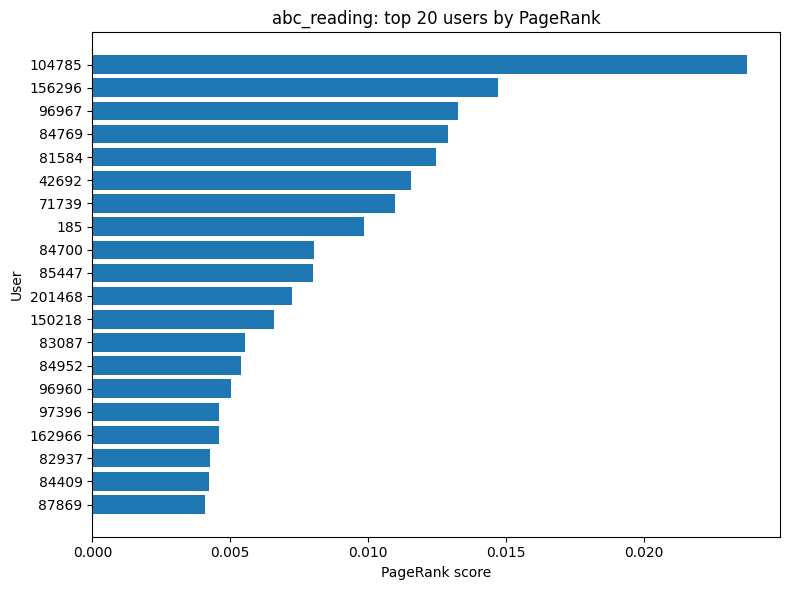


Saved:
  data/interim/abc_reading_edges_clean.parquet
  data/interim/abc_reading_net_features_clean.parquet
  data/interim/abc_reading_engagement_features_clean.parquet


In [16]:
# Clean self-loops, rebuild the graph, recompute network metrics,
# and recompute per-user engagement without self-loops.
# This cell replaces the earlier graph/metrics cell end-to-end.

import os
from pathlib import Path
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Safety: these must exist from earlier steps
assert "edges" in globals(), "Expected 'edges' DataFrame in memory."
assert "prof_df" in globals(), "Expected 'prof_df' DataFrame in memory."

# 0) Remove self-loops at the edge-list level
n_edges_before = len(edges)
self_mask = edges["src_user_id"] == edges["dst_user_id"]
n_self = int(self_mask.sum())
edges_clean = edges.loc[~self_mask].copy()
print("Self-loop cleanup")
print("-----------------")
print(f"edges before : {n_edges_before:,}")
print(f"self-loops   : {n_self:,} ({n_self / max(1, n_edges_before):.2%})")
print(f"edges after  : {len(edges_clean):,}")

# 1) Build DiGraph from cleaned edges
G = nx.DiGraph()
G.add_edges_from(edges_clean[["src_user_id", "dst_user_id"]].itertuples(index=False, name=None))

print("\nGraph overview (clean)")
print("----------------------")
print(f"nodes: {G.number_of_nodes():,}")
print(f"edges: {G.number_of_edges():,}")

# 2) Degree metrics
in_deg = dict(G.in_degree())    # how many distinct users interacted with a user
out_deg = dict(G.out_degree())  # how many distinct users a user interacted with

# 3) PageRank (standard settings)
try:
    pr = nx.pagerank(G, alpha=0.85, max_iter=100, tol=1e-06)
except nx.PowerIterationFailedConvergence:
    pr = nx.pagerank(G, alpha=0.85, max_iter=200, tol=1e-05)

# 4) k-core number (requires no self-loops; we already removed them)
core = nx.core_number(G.to_undirected())

# 5) Assemble per-user network features
net_feat = pd.DataFrame({
    "user_id": list(G.nodes()),
    "in_degree": pd.Series(in_deg),
    "out_degree": pd.Series(out_deg),
    "pagerank": pd.Series(pr),
    "kcore": pd.Series(core),
}).fillna(0)

# 6) Recompute per-user engagement received (exclude self-interactions)
eng = (
    edges_clean
    .groupby(["dst_user_id", "interact_type"])
    .size()
    .unstack(fill_value=0)
    .rename_axis(None, axis=1)
)
for col in ["comment", "reposts"]:
    if col not in eng.columns:
        eng[col] = 0
eng["total_engagement"] = eng["comment"] + eng["reposts"]
eng = eng.reset_index().rename(columns={"dst_user_id": "user_id"})

# 7) Join with profiles; rebuild feature table for this product
feat = (
    eng.merge(
        prof_df[["user_id", "user_followers", "user_friends"]],
        on="user_id",
        how="left",
    )
    .fillna({"user_followers": 0, "user_friends": 0})
)
feat["engagement_per_follower"] = feat["total_engagement"] / feat["user_followers"].clip(lower=1)
feat["engagement_per_1000_followers"] = 1000.0 * feat["engagement_per_follower"]

# 8) Small, readable summaries
top_in = net_feat.sort_values("in_degree", ascending=False).head(10)[["user_id","in_degree"]]
top_pr = net_feat.sort_values("pagerank", ascending=False).head(10)[["user_id","pagerank"]]

print("\nTop users by in-degree (distinct people who interacted)")
display(top_in)

print("\nTop users by PageRank (graph influence)")
display(top_pr)

# 9) Simple charts: top 20 by in-degree and PageRank
top20_in = net_feat.sort_values("in_degree", ascending=False).head(20).sort_values("in_degree")
plt.figure(figsize=(8,6))
plt.barh(top20_in["user_id"].astype(str), top20_in["in_degree"].to_numpy())
plt.xlabel("In-degree (number of users who interacted)")
plt.ylabel("User")
plt.title(f"{TARGET_PRODUCT}: top 20 users by in-degree")
plt.tight_layout()
plt.show()

top20_pr = net_feat.sort_values("pagerank", ascending=False).head(20).sort_values("pagerank")
plt.figure(figsize=(8,6))
plt.barh(top20_pr["user_id"].astype(str), top20_pr["pagerank"].to_numpy())
plt.xlabel("PageRank score")
plt.ylabel("User")
plt.title(f"{TARGET_PRODUCT}: top 20 users by PageRank")
plt.tight_layout()
plt.show()

# 10) Save interim outputs (clean versions)
interim_dir = Path("data/interim")
os.makedirs(interim_dir, exist_ok=True)
edges_path = interim_dir / f"{TARGET_PRODUCT}_edges_clean.parquet"
net_path = interim_dir / f"{TARGET_PRODUCT}_net_features_clean.parquet"
feat_path = interim_dir / f"{TARGET_PRODUCT}_engagement_features_clean.parquet"

try:
    edges_clean.to_parquet(edges_path, index=False)
    net_feat.to_parquet(net_path, index=False)
    feat.to_parquet(feat_path, index=False)
    print(f"\nSaved:\n  {edges_path}\n  {net_path}\n  {feat_path}")
except Exception as e:
    # fallback to CSV if Parquet fails locally
    edges_csv = interim_dir / f"{TARGET_PRODUCT}_edges_clean.csv"
    net_csv = interim_dir / f"{TARGET_PRODUCT}_net_features_clean.csv"
    feat_csv = interim_dir / f"{TARGET_PRODUCT}_engagement_features_clean.csv"
    edges_clean.to_csv(edges_csv, index=False)
    net_feat.to_csv(net_csv, index=False)
    feat.to_csv(feat_csv, index=False)
    print(f"\nParquet save failed ({e}). Saved CSV instead:\n  {edges_csv}\n  {net_csv}\n  {feat_csv}")

In [17]:
# Batch across all products: build edges, clean self-loops, compute network features,
# and save interim files for each product. Prints a short summary per product.

import json
from pathlib import Path
import pandas as pd
import networkx as nx

root = DATA_ROOT
products = sorted({
    p.name.replace("_profile.graph.anon", "") for p in root.glob("*_profile.graph.anon")
} & {
    p.name.replace("_interaction.graph.anon", "") for p in root.glob("*_interaction.graph.anon")
})

batch_summary = []

for prod in products:
    print(f"\n=== {prod} ===")

    # Load profiles (for followers/friends join later)
    with (root / f"{prod}_profile.graph.anon").open("r", encoding="utf-8") as f:
        prof_obj = json.load(f)
    prof_df = pd.DataFrame.from_dict(prof_obj, orient="index").reset_index(drop=True)
    for col in ["user_id", "user_followers", "user_friends"]:
        if col not in prof_df.columns:
            prof_df[col] = pd.NA
    prof_df["user_id"] = pd.to_numeric(prof_df["user_id"], errors="coerce").astype("Int64")
    prof_df["user_followers"] = pd.to_numeric(prof_df["user_followers"], errors="coerce").fillna(0).astype("int64")
    prof_df["user_friends"] = pd.to_numeric(prof_df["user_friends"], errors="coerce").fillna(0).astype("int64")

    # Load interactions → edges
    with (root / f"{prod}_interaction.graph.anon").open("r", encoding="utf-8") as f:
        inter_obj = json.load(f)

    rows = []
    for key_user_str, lst in inter_obj.items():
        try:
            dst = int(key_user_str)
        except Exception:
            continue
        for rec in lst or []:
            try:
                src = int(rec.get("interact_id"))
            except Exception:
                continue
            itype = str(rec.get("interact_type", ""))
            rows.append((src, dst, itype))
    edges = pd.DataFrame(rows, columns=["src_user_id", "dst_user_id", "interact_type"]).astype(
        {"src_user_id": "int64", "dst_user_id": "int64"}
    )

    # Remove self-loops
    self_mask = edges["src_user_id"] == edges["dst_user_id"]
    edges_clean = edges.loc[~self_mask].copy()

    # Build graph and compute metrics
    G = nx.DiGraph()
    G.add_edges_from(edges_clean[["src_user_id", "dst_user_id"]].itertuples(index=False, name=None))

    in_deg = dict(G.in_degree())
    out_deg = dict(G.out_degree())

    try:
        pr = nx.pagerank(G, alpha=0.85, max_iter=100, tol=1e-06)
    except nx.PowerIterationFailedConvergence:
        pr = nx.pagerank(G, alpha=0.85, max_iter=200, tol=1e-05)

    core = nx.core_number(G.to_undirected())

    net_feat = pd.DataFrame({
        "user_id": list(G.nodes()),
        "in_degree": pd.Series(in_deg),
        "out_degree": pd.Series(out_deg),
        "pagerank": pd.Series(pr),
        "kcore": pd.Series(core),
    }).fillna(0)

    # Engagement received (excluding self-interactions)
    eng = (
        edges_clean.groupby(["dst_user_id", "interact_type"]).size()
        .unstack(fill_value=0).rename_axis(None, axis=1)
    )
    for col in ["comment", "reposts"]:
        if col not in eng.columns:
            eng[col] = 0
    eng["total_engagement"] = eng["comment"] + eng["reposts"]
    eng = eng.reset_index().rename(columns={"dst_user_id": "user_id"})

    # Join with followers/friends
    feat = (
        eng.merge(prof_df[["user_id", "user_followers", "user_friends"]], on="user_id", how="left")
           .fillna({"user_followers": 0, "user_friends": 0})
    )
    feat["engagement_per_follower"] = feat["total_engagement"] / feat["user_followers"].clip(lower=1)

    # Save interim files
    out_dir = Path("data/interim")
    out_dir.mkdir(parents=True, exist_ok=True)
    net_feat.to_parquet(out_dir / f"{prod}_net_features_clean.parquet", index=False)
    feat.to_parquet(out_dir / f"{prod}_engagement_features_clean.parquet", index=False)
    edges_clean.to_parquet(out_dir / f"{prod}_edges_clean.parquet", index=False)

    # Small summary line
    line = {
        "product": prod,
        "users": int(net_feat.shape[0]),
        "edges": int(edges_clean.shape[0]),
        "engaged_users": int(feat.shape[0]),
        "self_loops_removed": int(self_mask.sum()),
        "top_in_degree": int(net_feat["in_degree"].max()) if not net_feat.empty else 0,
    }
    batch_summary.append(line)
    print(line)

# Show batch summary table
batch_df = pd.DataFrame(batch_summary).sort_values("users", ascending=False)
display(batch_df)


=== abc_reading ===
{'product': 'abc_reading', 'users': 70257, 'edges': 439620, 'engaged_users': 9068, 'self_loops_removed': 18893, 'top_in_degree': 5676}

=== electric_toothbrush ===
{'product': 'electric_toothbrush', 'users': 43610, 'edges': 161551, 'engaged_users': 2758, 'self_loops_removed': 1465, 'top_in_degree': 9527}

=== intelligent_floor_scrubber ===
{'product': 'intelligent_floor_scrubber', 'users': 63618, 'edges': 356506, 'engaged_users': 7556, 'self_loops_removed': 13670, 'top_in_degree': 5341}

=== ruby_face_cream ===
{'product': 'ruby_face_cream', 'users': 66247, 'edges': 121861, 'engaged_users': 4871, 'self_loops_removed': 4998, 'top_in_degree': 7963}

=== spark_thinking ===
{'product': 'spark_thinking', 'users': 58509, 'edges': 473594, 'engaged_users': 9616, 'self_loops_removed': 16837, 'top_in_degree': 8159}

=== supor_boosted_showerhead ===
{'product': 'supor_boosted_showerhead', 'users': 138424, 'edges': 241365, 'engaged_users': 8355, 'self_loops_removed': 6376, 'to

,product,users,edges,engaged_users,self_loops_removed,top_in_degree
5,supor_boosted_showerhead,138424,241365,8355,6376,16777
0,abc_reading,70257,439620,9068,18893,5676
3,ruby_face_cream,66247,121861,4871,4998,7963
2,intelligent_floor_scrubber,63618,356506,7556,13670,5341
4,spark_thinking,58509,473594,9616,16837,8159
1,electric_toothbrush,43610,161551,2758,1465,9527


In [19]:
# Combine per-product features into one modeling table and add product_info flags
# Replaces the previous cell end-to-end.

import json
from pathlib import Path
import pandas as pd
import numpy as np

PROC_DIR = Path("data/processed")
INTERIM_DIR = Path("data/interim")
PROC_DIR.mkdir(parents=True, exist_ok=True)

# Load product_info (JSON array) to get official influencers per product
info_path = DATA_ROOT / "product_info.jsonl"
with info_path.open("r", encoding="utf-8") as f:
    info_list = json.load(f)
info_df = pd.DataFrame(info_list)

def to_int_list(x):
    if isinstance(x, list):
        out = []
        for v in x:
            try:
                out.append(int(v))
            except Exception:
                pass
        return out
    return []

info_df["influencer_ids"] = info_df["influencer_ids"].apply(to_int_list)
official_map = {row["product_name"]: set(row["influencer_ids"]) for _, row in info_df.iterrows()}

# Discover per-product interim files
net_files = sorted(INTERIM_DIR.glob("*_net_features_clean.parquet"))

all_rows = []
for net_path in net_files:
    prod = net_path.name.replace("_net_features_clean.parquet", "")
    eng_path = INTERIM_DIR / f"{prod}_engagement_features_clean.parquet"
    if not eng_path.exists():
        print(f"Skip {prod}: missing {eng_path.name}")
        continue

    net = pd.read_parquet(net_path)
    eng = pd.read_parquet(eng_path)

    # Merge network + engagement
    df = eng.merge(net, on="user_id", how="left")

    # Add product name and official influencer flag
    df["product_name"] = prod
    df["is_official_influencer"] = df["user_id"].astype("int64").isin(official_map.get(prod, set())).astype("int8")

    # Stabilized (log1p) versions for skewed counts
    for col in ["user_followers", "user_friends", "comment", "reposts", "total_engagement",
                "in_degree", "out_degree"]:
        if col in df.columns:
            df[f"log1p_{col}"] = np.log1p(df[col].astype(float))

    # Safe transform for PageRank (avoid log(0))
    pr_series = df.get("pagerank", pd.Series(0.0, index=df.index)).astype(float).fillna(0.0)
    df["log1p_pagerank"] = np.log1p(pr_series.clip(lower=1e-12))

    all_rows.append(df)

if not all_rows:
    raise RuntimeError("No per-product interim files found. Make sure earlier steps ran.")

features_all = pd.concat(all_rows, ignore_index=True)

# Small sanity report
print("Modeling table")
print("--------------")
print(f"rows: {features_all.shape[0]:,}, cols: {features_all.shape[1]}")
print("columns (sample):", sorted(features_all.columns.tolist())[:12], "...")

cov = features_all.groupby("product_name")["is_official_influencer"].sum().sort_values(ascending=False)
print("\nOfficial influencers present per product:")
display(cov.to_frame("count_in_model"))

# Save
out_path = PROC_DIR / "features_per_product.parquet"
features_all.to_parquet(out_path, index=False)
print(f"\nSaved: {out_path}")

Modeling table
--------------
rows: 42,224, cols: 21
columns (sample): ['comment', 'engagement_per_follower', 'in_degree', 'is_official_influencer', 'kcore', 'log1p_comment', 'log1p_in_degree', 'log1p_out_degree', 'log1p_pagerank', 'log1p_reposts', 'log1p_total_engagement', 'log1p_user_followers'] ...

Official influencers present per product:


,count_in_model
product_name,
ruby_face_cream,11
electric_toothbrush,8
supor_boosted_showerhead,6
intelligent_floor_scrubber,5
spark_thinking,5
abc_reading,4



Saved: data/processed/features_per_product.parquet
